In [9]:
import cv2
import skimage.io as io
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import helper as helper
from dataset import *
import imageio


In [10]:
label_path='../labels/coco/labels/val2017/000000007108.txt'
with open(label_path) as box:
    box=box.read()
    box=pd.DataFrame([x.split() for x in box.rstrip('\n').split('\n')],columns=['class','xc','yc','w','h'])

b= box.values.astype(np.float32)
bboxes=b
b=torch.tensor(b)
labels = b.T[0].reshape(b.shape[0], 1)
one_hot_target = (labels == torch.arange(80).reshape(1, 80)).float()
conf=torch.ones([b.shape[0],1])
boxes=torch.cat((b.T[1:],conf.T,one_hot_target.T)).T

img_path='../images/val2017/000000007108.jpg'
img=cv2.imread(img_path)[:,:,::-1] 

sample={'images': img,
        'boxes': boxes}

(h,w,c)=img.shape

bboxes[:,1]=bboxes[:,1]*w
bboxes[:,2]=bboxes[:,2]*h
bboxes[:,3]=bboxes[:,3]*w
bboxes[:,4]=bboxes[:,4]*h
bboxes[:,1]=bboxes[:,1]-bboxes[:,3]/2
bboxes[:,2]=bboxes[:,2]-bboxes[:,4]/2
bboxes[:,3]=bboxes[:,1]+bboxes[:,3]
bboxes[:,4]=bboxes[:,2]+bboxes[:,4]
print(bboxes)


[[ 20.        125.69025    26.39006   418.32      420.7199   ]
 [ 20.        401.19006    77.46982   632.98975   426.       ]
 [ 20.        338.12994     0.9099388 504.32       93.55983  ]
 [ 20.        120.88031   219.        203.62015   345.95013  ]
 [ 20.        567.63007    49.78981   637.34015   372.88995  ]]


In [1]:
import pandas as pd

df=pd.DataFrame()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [55]:
import imgaug as ia
from imgaug import parameters as iap
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


image = sample['images']

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=b[1], y1=b[2], x2=b[3], y2=b[4], label=b[0]) for b in bboxes], shape=image.shape)

seq = iaa.OneOf([
            iaa.Sequential([
                iaa.LinearContrast(alpha=(0.1, 1.9)),
                iaa.Fliplr(0.5)
            ]),
            iaa.Sequential([
                iaa.Grayscale(alpha=(0.1, 0.9)),
                iaa.Affine(
                translate_px={"y": (-150, 150)}
            )
            ]),
            iaa.Sequential([
                iaa.Solarize(0.5, threshold=(0, 256)),
                iaa.ShearX((-10, 10))
            ]),
            iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.ShearY((-10, 10))
            ]),
            iaa.Sequential([
                iaa.Multiply((0.8, 1.2), per_channel=0.2),
                iaa.Affine(
                rotate=(-30, 30)
            )
            ]),
            iaa.Sequential([
                iaa.HistogramEqualization(),
                iaa.Affine(
                translate_px={"x": (-150, 150)}
            )
            ]),
            iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}
            )
            ])
        ])

# Augment BBs and images.
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

# image with BBs before/after augmentation (shown below)
# image_before = bbs.draw_on_image(image, size=2)
# image_after = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])

BB 0: (125.6902, 26.3901, 418.3200, 420.7199) -> (127.6176, -0.9098, 417.3448, 434.5335)
BB 1: (401.1901, 77.4698, 632.9897, 426.0000) -> (400.3848, 88.8768, 629.8853, 469.9741)
BB 2: (338.1299, 0.9099, 504.3200, 93.5598) -> (337.9501, 3.4571, 502.4918, 119.4562)
BB 3: (120.8803, 219.0000, 203.6201, 345.9501) -> (122.8553, 191.0243, 204.7745, 329.5991)
BB 4: (567.6301, 49.7898, 637.3401, 372.8900) -> (565.1739, 84.5811, 634.1925, 417.4752)


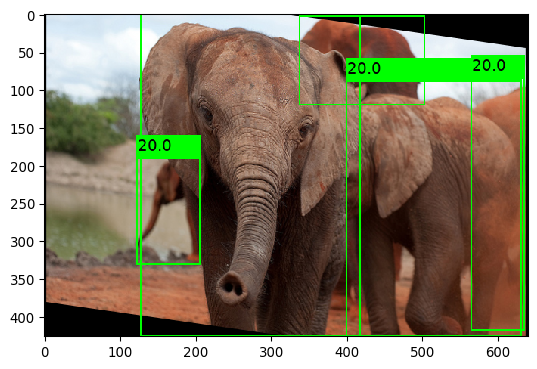

[[20.          0.42575184  0.5         0.45269877  1.        ]
 [20.          0.80489844  0.60431546  0.35859454  0.7913691 ]
 [20.          0.65659523  0.1442645   0.2570963   0.2722983 ]
 [20.          0.25596082  0.6110604   0.12799871  0.32529294]
 [20.          0.937005    0.5892679   0.10784161  0.7814417 ]]


In [56]:
new_bboxes=bbs_aug.to_xyxy_array()
bbs_aug=bbs_aug.remove_out_of_image().clip_out_of_image()

ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

labels=np.array([[box.label for box in bbs_aug.bounding_boxes]]).T
new_bboxes=bbs_aug.to_xyxy_array()
np.hstack((labels,new_bboxes))

bboxes_final=helper.convert2_rel(np.hstack((labels,new_bboxes)),image_aug.shape)
print(bboxes_final)

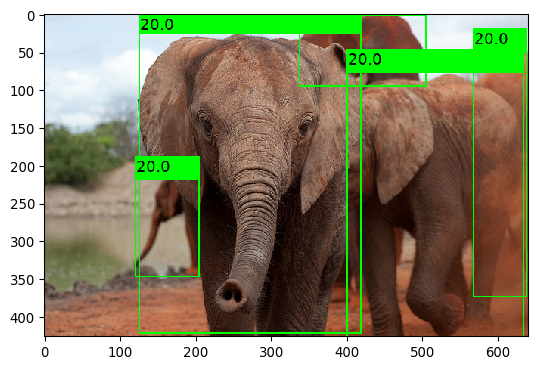

In [22]:
ia.imshow(bbs.draw_on_image(image, size=2))
imageio.imwrite("elephants.jpg", bbs.draw_on_image(image, size=2))
bbs_aug.draw_on_image(image_aug, size=2)
imageio.imwrite("elephants_aug.jpg", bbs_aug.draw_on_image(image_aug, size=2))

In [ ]:
box=open("../detections/000000007108.txt")
box=box.read()
box=pd.DataFrame([x.split() for x in box.rstrip('\n').split('\n')],columns=['class','conf','xc','yc','w','h'])
b= box.values.astype(np.float32)
b=torch.tensor(b)
labels = b.T[0].reshape(b.shape[0], 1)
objectness = b.T[1].reshape(b.shape[0], 1)
one_hot_target = (labels == torch.arange(80).reshape(1, 80)).float()
# conf=torch.ones([b.shape[0],1])

boxes=torch.cat((b.T[2:],objectness.T,one_hot_target.T)).T
print(boxes.shape)
# plt.imshow(draw_rect(sample['images'], boxes))
# plt.savefig('elephants.png')

In [ ]:
import torchvision.ops.boxes as nms_box
import util as util
abs_boxes=util.get_abs_coord(boxes[:,0:4].unsqueeze(0)).squeeze(1)
print(abs_boxes.shape)
fb=nms_box.nms(abs_boxes,boxes[:,4].cuda(),0.5)
print(nms_box.box_iou(abs_boxes,abs_boxes))
print(fb)

In [ ]:
test1=torch.tensor([[15.0,25.0,30.0,50.0],[20.0,30.0,40.0,50.0]])
test2=torch.tensor([[15.0,25.0,35.0,45.0],[20.0,30.0,40.0,50.0]])

fb=nms_box.nms(test1,torch.tensor([0.9,0.9]),0.3)
print(nms_box.box_iou(boxes[:,0:4],boxes[:,0:4]))
print(fb)

In [61]:
test1=torch.tensor([[0.15,0.25,0.3,0.5],[.20,.07,.04,.074]])
xc=test1[:,:1]
xc==1

tensor([[False],
        [False]])

In [62]:
0.99999*416/32

12.999870000000001

In [6]:
import torch
test=torch.rand([62,9,85])
mask=torch.empty([0,85],dtype=torch.bool)
test[0,:,:]=test[0,mask]

IndexError: The shape of the mask [0, 85] at index 0 does not match the shape of the indexed tensor [9, 85] at index 0

In [ ]:
diff=1
import random
print(random.uniform(1,2))
def shear(sample):
    
    img=sample['images']
    bboxes=sample['boxes']
    shear_factor = 0.6

    w,h = img.shape[1], img.shape[0]
    
    if shear_factor < 0:
        sample = RandomHorizontalFlip(-1)(sample)
        img=sample['images']
        bboxes=sample['boxes']

    
    M = np.array([[1, abs(shear_factor), 0],[0,1,0]])

    nW =  img.shape[1] + abs(shear_factor*img.shape[0])

    bboxes[:,0] += bboxes[:,1]* abs(torch.tan(torch.tensor([shear_factor])))
    bboxes[:,2] += bboxes[:,3]* abs(torch.tan(torch.tensor([shear_factor])))
    


    img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))


#     if shear_factor < 0:
#         sample = RandomHorizontalFlip(-1)(sample)
#         img=sample['images']
#         bboxes=sample['boxes']
#         print(bboxes)
#     plt.imshow(draw_rect(img, bboxes))

    img = cv2.resize(img, (w,h))

    scale_factor_x = nW / w
    print(scale_factor_x)
    bboxes[:,:4] /= torch.tensor([scale_factor_x, 1, scale_factor_x, 1])
    print(bboxes)
    return img, bboxes

In [ ]:
import os

os.mkdir('../pth/test/')

In [ ]:
import cv2 
import pickle as pkl
import numpy as np 
import matplotlib.pyplot as plt

def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """
    
    im = im.copy()
    h=im.shape[0]
    w=im.shape[1]
    cords[:,0]=cords[:,0]*w
    cords[:,1]=cords[:,1]*h
    cords[:,2]=cords[:,2]*w
    cords[:,3]=cords[:,3]*h
    if not color:
        color = [255,255,255]
    for cord in cords:
        pt1, pt2 = (cord[0]-cord[2]/2, cord[1]-cord[3]/2) , (cord[0]+cord[2]/2, cord[1]+cord[3]/2)
        
#         pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
        
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

In [ ]:

import matplotlib.pyplot as plt

translate=RandomTranslate()
flip=RandomVerticalFlip()

rotate = RandomRotate(20) 
sample=flip(sample)
sample=translate(sample)
sample = rotate(sample)

plt.imshow(draw_rect(img, bboxes))

In [ ]:
img, bboxes = rotate(sample)

plt.imshow(draw_rect(img, bboxes))


In [ ]:
print(helper.get_corners(bboxes))

In [ ]:
import torch

a=torch.tensor([[[1,2,2,4,0,0,0,1],[2,3,5,3,0,0,1,0]]])
print(a.shape)
b=((a[:,:,4:]==1).nonzero())
b=b[:,-1].unsqueeze(0).unsqueeze(-1)
print(b.shape)
new=a[:,:,:4]
print(new.shape)
new=torch.cat((new.T,b.T)).T
print(new)
sorted_pred=torch.sort(new[0,:,4],descending=False)
print(sorted_pred)

In [ ]:
b = box.values.astype(np.float32)
b=torch.tensor(b)
labels = b.T[0].reshape(b.shape[0], 1)
one_hot_target = (labels == torch.arange(80).reshape(1, 80)).float()
conf=torch.ones([b.shape[0],1])
boxes=torch.cat((b.T[1:],conf.T,one_hot_target.T)).T




In [ ]:
file_name='images/train2017.zip'
with ZipFile(file_name, 'r') as zip:
    image=zip.read('train2017/000000408542.jpg')
    img = cv2.imdecode(np.frombuffer(image, np.uint8),1)
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    io.imshow(im_rgb)
    io.imsave('fig.png',im_rgb)

In [ ]:
df=pd.read_csv('pointers/train2017.txt',names=['filename'])

In [ ]:
df['box']=df['filename'].apply(lambda x: 'coco/labels/'+x.split('.')[0]+'.txt')

In [ ]:
df['box']

In [1]:
from dataset import *
import timeit 
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import time
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import test as tester
import sys
import timeit
import torch.autograd
import helper as helper
from torch.utils.tensorboard import SummaryWriter
import pandas as pd



net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph.to(device='cuda')
cx_cy=net.cx_cy.to(device='cuda')
stride=net.stride.to(device='cuda')


hyperparameters={'lr':0.0001,
                 'epochs':10,
                 'batch_size':8,
                 'weight_decay':0.001,
                 'momentum':0.9,
                 'optimizer':'sgd',
                 'alpha':0.5,
                 'gamma':0,
                 'lcoord':5,
                 'lno_obj':1,
                 'iou_type':(0,0,0),#(GIoU,DIoU,CIoU) default is 0,0,0 for iou
                 'iou_ignore_thresh':0.5,
                 'tfidf':True,
                 'idf_weights':True,
                 'tfidf_col_names':['obj_freq','area','xc','yc','softmax'], #default is ['obj_freq/img_freq','area','xc','yc','softmax']-->[class_weights,scale_weights,xweights,yweights,softmax/no_softmax]
                 'augment':0,
                 'workers':4,
                 'path':'test_iou',
                 'reduction':'sum'}

print(hyperparameters)

if (hyperparameters['idf_weights']==True):
    hyperparameters['idf_weights']=pd.read_csv('../idf.csv')
else:
    hyperparameters['idf_weights']=False
        
'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../'+hyperparameters['path']
    weights = torch.load(PATH)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we https://pytorch.org/docs/stable/data.html#torch.utils.data.Datasetare on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if (torch.cuda.device_count() > 1):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
        model.load_state_dict(weights)
    else:
        model=net
        model.to(device)
        model.load_state_dict(weights)
        
except FileNotFoundError: 
    net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    if (torch.cuda.device_count() > 1):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
    else:
        model=net
        
if hyperparameters['augment']>0:
    transformed_dataset=Coco(partition='train',transform=transforms.Compose([Augment(hyperparameters['augment']),ResizeToTensor(inp_dim)]))
else:
    transformed_dataset=Coco(partition='train',transform=transforms.Compose([ResizeToTensor(inp_dim)]))
    


writer = SummaryWriter('../results/'+hyperparameters['path'])
dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=hyperparameters['batch_size']
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=False,collate_fn=helper.my_collate, num_workers=hyperparameters['workers'])


if hyperparameters['optimizer']=='sgd':
    optimizer = optim.SGD(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'], momentum=hyperparameters['momentum'])
elif hyperparameters['otimizer']=='adam':
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])

lambda1 = lambda epoch: 0.95**epoch
scheduler=optim.lr_scheduler.LambdaLR(optimizer, lambda1, last_epoch=-1)
mAP_max=0
epochs=hyperparameters['epochs']
total_loss=0
write=0
misses=0
avg_iou=0
break_flag=0
for e in range(2):
    for images,targets,img_names in dataloader:
        print(img_names)
        break
    


KeyboardInterrupt: 

In [112]:
print(noobj_box.shape)
print(no_obj.shape)
print(resp_raw_pred[:,4])

torch.Size([84699])
torch.Size([84275])
tensor([[ 2.3222e-01,  2.8907e-01,  1.4605e-01,  ...,  4.7911e-04,
          2.4028e-03,  1.5908e-03],
        [-1.9761e-01, -1.3025e+00,  5.8112e-01,  ...,  7.1085e-05,
          1.0018e-04,  5.8199e-05],
        [-8.2587e-01, -5.5322e-01, -3.3853e-01,  ...,  7.6819e-08,
          1.9438e-06,  1.2375e-07],
        ...,
        [-1.3852e+00, -4.4429e-01,  1.0674e-01,  ...,  1.1832e-11,
          8.2438e-09,  2.3267e-09],
        [ 6.6969e-01, -1.1589e-01,  5.7138e-01,  ...,  2.0558e-03,
          2.7126e-04,  9.2891e-04],
        [ 8.5629e-01,  8.8688e-01,  1.0599e-01,  ...,  1.1250e-04,
          4.8833e-05,  3.2650e-05]], device='cuda:0', grad_fn=<SelectBackward>)


In [34]:
def get_idf(gt,mask):
    corpus_length=sum(mask)
#     tf=torch.tensor([1/mask[i] for i in range(len(mask)) for j in range(mask[i])]).cuda()
    tf=1
    idf=gt[:,5:].sum(axis=0).cuda()

    idf=torch.log(corpus_length/idf)
    
    classes=gt[:,5:].max(1)[1]
    print(classes)
    tfidf=tf*idf[classes]
    tfidf=torch.softmax(tfidf,dim=0)
    
    return tfidf

In [3]:
ran=torch.rand(targets.shape[0])
print(ran.shape)
print(torch.softmax(ran,dim=0))

torch.Size([79])
tensor([0.0161, 0.0169, 0.0085, 0.0100, 0.0073, 0.0076, 0.0145, 0.0074, 0.0094,
        0.0156, 0.0125, 0.0106, 0.0160, 0.0167, 0.0156, 0.0130, 0.0164, 0.0134,
        0.0179, 0.0171, 0.0129, 0.0171, 0.0080, 0.0087, 0.0087, 0.0132, 0.0141,
        0.0078, 0.0165, 0.0084, 0.0074, 0.0134, 0.0080, 0.0140, 0.0164, 0.0188,
        0.0145, 0.0091, 0.0142, 0.0185, 0.0080, 0.0133, 0.0184, 0.0171, 0.0135,
        0.0187, 0.0110, 0.0124, 0.0085, 0.0135, 0.0157, 0.0176, 0.0165, 0.0170,
        0.0082, 0.0172, 0.0079, 0.0164, 0.0094, 0.0084, 0.0097, 0.0197, 0.0088,
        0.0105, 0.0075, 0.0143, 0.0103, 0.0097, 0.0157, 0.0090, 0.0110, 0.0075,
        0.0166, 0.0137, 0.0175, 0.0121, 0.0091, 0.0073, 0.0094])


In [26]:
print(targets.shape[0])


73


In [66]:
area=torch.tensor(df['area'])
classes=targets.squeeze(0)[:,5:].max(1)[1].cpu()
gt_area=area[classes.tolist()]
target_area=targets.squeeze(0)[:,3]*targets.squeeze(0)[:,2]

target_area=target_area.cpu()
res=torch.abs(target_area-gt_area)
print(res)

tensor([0.2950, 0.1824, 0.0845, 0.0408, 0.0791, 0.0231, 0.0070, 0.0667, 0.0623,
        0.0716, 0.0742, 0.0748, 0.0604, 0.0621, 0.0765, 0.0795, 0.0015, 0.0128,
        0.0762, 0.0066, 0.0145, 0.0757, 0.0757, 0.3364, 0.0546, 0.0726, 0.0014,
        0.0609, 0.0489, 0.3533, 0.0497, 0.0507, 0.0363, 0.6154, 0.0723, 0.0216,
        0.1021, 0.1866, 0.1869, 0.1873, 0.0041, 0.1081, 0.0268, 0.0272, 0.0815,
        0.0507, 0.2071, 0.0459, 0.0157, 0.0125, 0.0272, 0.2096, 0.0042, 0.0486,
        0.0075])


In [50]:
xc=torch.tensor(df['xc'])
classes=targets.squeeze(0)[:,5:].max(1)[1].cpu()
gt_xc=area[classes.tolist()]
target_xc=targets.squeeze(0)[:,0]
target_xc=target_xc.cpu().numpy()
print(np.absolute(target_xc-gt_xc))

[0.12139964 0.26815036 0.32280965 0.42259035 0.33095306 0.05774618
 0.46207964 0.39824965 0.16512033 0.00201038 0.03446693 0.04951966
 0.03155965 0.35487035 0.01142034 0.36397308 0.08058038 0.01102266
 0.14592865 0.01862191 0.28152607 0.21493664 0.48811838 0.05130725
 0.43893573 0.40452872 0.02157965 0.15894283 0.11436319 0.02851082
 0.10136382 0.05988613 0.27940688 0.00138811 0.01095281 0.11959717
 0.4539938  0.17061221 0.15487021 0.01704922 0.23119464 0.0740901
 0.01383859 0.00497442 0.28713982 0.02960972 0.09379225 0.05948302
 0.0428628  0.05745264 0.01851755 0.06174522 0.29214295 0.05704292
 0.26241608]


In [52]:
area=df['yc'].to_numpy()
classes=targets.squeeze(0)[:,5:].max(1)[1].cpu()
gt_yc=area[classes.tolist()]
target_yc=targets.squeeze(0)[:,0]
target_yc=target_yc.cpu().numpy()
print(np.absolute(target_yc-gt_yc))

[0.11743551 0.27211449 0.31884552 0.42655447 0.28973773 0.00687193
 0.45811552 0.39428552 0.16908446 0.0059745  0.07568226 0.04555553
 0.02759552 0.35883448 0.01538447 0.32275775 0.08454451 0.00705853
 0.14196452 0.01508472 0.3152327  0.21097252 0.49208251 0.13024759
 0.35999538 0.32558837 0.01761553 0.16549852 0.10780749 0.03443755
 0.10729055 0.00335054 0.33594246 0.01907905 0.03986539 0.13611263
 0.3442395  0.15661569 0.14087369 0.0030527  0.25731987 0.05362294
 0.06439578 0.04558276 0.23632162 0.04768261 0.04540914 0.01462085
 0.051293   0.08357788 0.06907474 0.0133621  0.39431142 0.03842269
 0.21137784]


In [ ]:
import torchb
print(torch.uniform(10))b

<h1> Get location imbalance</h1>

In [8]:
from dataset import *
import timeit 
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import time
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import test as tester
import sys
import timeit
import torch.autograd
import helper as helper
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from torch import autograd



net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph.to(device='cuda')
cx_cy=net.cx_cy.to(device='cuda')
stride=net.stride.to(device='cuda')
print('YOLO version2')

hyperparameters={'lr': 0.00005, 
                 'epochs': 90,
                 'resume_from':15,
                 'coco_version': '2017', #can be either '2014' or '2017'
                 'batch_size': 8,
                 'weight_decay': 0.0005,
                 'momentum': 0.9, 
                 'optimizer': 'sgd', 
                 'alpha': 0.9, 
                 'gamma': 0, 
                 'lcoord': 1,
                 'lno_obj': 1,
                 'iou_type': (1, 0, 0),
                 'iou_ignore_thresh': 0.23, 
                 'tfidf': True, 
                 'idf_weights': True, 
                 'tfidf_col_names': ['img_freq', 'none', 'none', 'none', 'no_softmax'],
                 'augment': 0, 
                 'workers': 4, 
                 'path': 'test_iou', 
                 'reduction': 'sum'}

print(hyperparameters)
coco_version=hyperparameters['coco_version']
if (hyperparameters['idf_weights']==True):
    hyperparameters['idf_weights']=pd.read_csv('../idf.csv')
else:
    hyperparameters['idf_weights']=False
        
'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pth/'+hyperparameters['path']+'/'
    weights = torch.load(PATH+hyperparameters['path']+'_best.pth')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we https://pytorch.org/docs/stable/data.html#torch.utils.data.Datasetare on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if (torch.cuda.device_count() > 2):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
        model.load_state_dict(weights)
    else:
        model=net
        model.to(device)
        model.load_state_dict(weights)
        
except FileNotFoundError:
    try:
        os.mkdir(PATH)
    except FileExistsError:
        print('path already exist')
#     net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    if (torch.cuda.device_count() > 2):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
    else:
        model=net
        
if hyperparameters['augment']>0:
    transformed_dataset=Coco(partition='train',coco_version=coco_version,transform=transforms.Compose([Augment(hyperparameters['augment']),ResizeToTensor(inp_dim)]))
else:
    transformed_dataset=Coco(partition='train',coco_version=coco_version,transform=transforms.Compose([ResizeToTensor(inp_dim)]))
    


dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=hyperparameters['batch_size']
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=False,collate_fn=helper.my_collate, num_workers=hyperparameters['workers'])


if hyperparameters['optimizer']=='sgd':
    optimizer = optim.SGD(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'], momentum=hyperparameters['momentum'])
elif hyperparameters['otimizer']=='adam':
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=3)
mAP_max=0
epochs=hyperparameters['epochs']
resume_from=hyperparameters['resume_from']
break_flag=0
total=0
for images,targets,img_names in dataloader:
    targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
    targets=targets.cuda()
    fall_into_mask=util.get_fall_into_mask(targets,offset,strd,inp_dim)
    
    total=fall_into_mask.sum(axis=0)+total

YOLO version2
{'lr': 5e-05, 'epochs': 90, 'resume_from': 15, 'coco_version': '2017', 'batch_size': 8, 'weight_decay': 0.0005, 'momentum': 0.9, 'optimizer': 'sgd', 'alpha': 0.9, 'gamma': 0, 'lcoord': 1, 'lno_obj': 1, 'iou_type': (1, 0, 0), 'iou_ignore_thresh': 0.23, 'tfidf': True, 'idf_weights': True, 'tfidf_col_names': ['img_freq', 'none', 'none', 'none', 'no_softmax'], 'augment': 0, 'workers': 4, 'path': 'test_iou', 'reduction': 'sum'}
path already exist
cuda:0
Length of dataset is 117266



In [14]:
print(total.mean())
print(total.std())
print(total.min())
print(total.max())

tensor(2, device='cuda:0')
tensor(25194, device='cuda:0')


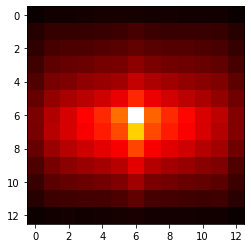

In [33]:

import matplotlib.pyplot as plt
import numpy as np

test=total[:507].reshape(13,13,3)

fig=plt.imshow(test[:,:,0].cpu(), cmap='hot')
# 
plt.savefig('heatmap13x13.png')


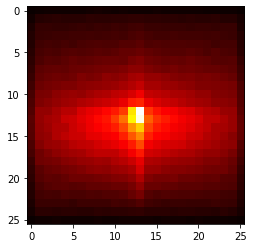

In [34]:
import matplotlib.pyplot as plt
import numpy as np

test=total[507:2028+507].reshape(26,26,3)

plt.imshow(test[:,:,0].cpu(), cmap='hot')
# plt.show()
plt.savefig('heatmap26x26.png')

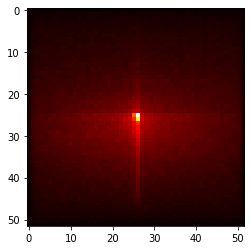

In [35]:
import matplotlib.pyplot as plt
import numpy as np

test=total[2028+507:].reshape(52,52,3)

plt.imshow(test[:,:,0].cpu(), cmap='hot')
# plt.show()
plt.savefig('heatmap52x52.png')

In [37]:
print(total.sum()/9)

tensor(849942, device='cuda:0')


In [43]:
nt=torch.tensor(total,dtype=torch.float)
idf=torch.log((nt.sum()/9+1)/(nt))
px = idf.numpy()
px = pd.DataFrame(px)
px.to_csv('loc_idf.csv')

<ipython-input-43-c76829044166>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nt=torch.tensor(total,dtype=torch.float)


tensor([ 6.9872,  6.9872,  6.9872,  ..., 12.9598, 12.9598, 12.9598])


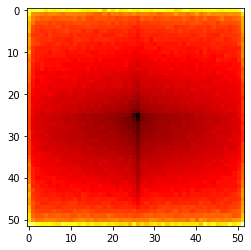

In [41]:
print(idf)
import matplotlib.pyplot as plt
import numpy as np

test=idf[2028+507:].reshape(52,52,3)

plt.imshow(test[:,:,0].cpu(), cmap='hot')
plt.show()
# plt.savefig('heatmap52x52.png')

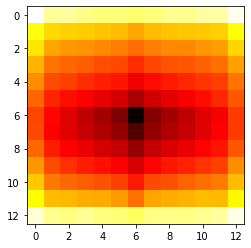

In [42]:

import matplotlib.pyplot as plt
import numpy as np

test=idf[:507].reshape(13,13,3)

fig=plt.imshow(test[:,:,0].cpu(), cmap='hot')
# 
plt.show()

In [2]:
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import pandas as pd
import time
import sys
import timeit
from dataset import *
import torchvision.ops.boxes as nms_box
import helper as helper
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
import json

net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph.cuda()
cx_cy=net.cx_cy.cuda()
stride=net.stride.cuda()

start_time = time.time()
'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pth/pretrained32_precomp_obj_soft.pth'
    weights = torch.load(PATH)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if torch.cuda.device_count() > 1:
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
    else:
        model=net

    model.to(device)
    
    
    model.load_state_dict(weights)
    model.eval()
except FileNotFoundError: 
    net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    model=net
    if torch.cuda.device_count() > 3:
      print("Using ", torch.cuda.device_count(), "GPUs!")
      model = nn.DataParallel(net)

    model.to(device)
    model.eval()




print('testing with '+ PATH +'\n')
transformed_dataset=Coco(partition='val',coco_version='2014',subset=0.1,
                                           transform=transforms.Compose([
                                            ResizeToTensor(inp_dim)
                                           ]))



dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=2

dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True,collate_fn=helper.my_collate, num_workers=4)

true_pos=0
false_pos=0
counter=0
iou_threshold=0.5
confidence=0.01
recall_counter=0
max_detections=None
prg_counter=0
annotations=[]
for images,targets,img_meta in dataloader:
#     print(images)
    inp=images.cuda()
    raw_pred = model(inp, torch.cuda.is_available())
    targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)

    raw_pred=raw_pred.to(device='cuda')
    true_pred=util.transform(raw_pred.clone(),pw_ph,cx_cy,stride)

    sorted_pred=torch.sort(true_pred[:,:,4],descending=True)
    pred_mask=sorted_pred[0]>confidence
    indices=[(sorted_pred[1][e,:][pred_mask[e,:]]) for e in range(pred_mask.shape[0])]
    pred_final=[true_pred[i,indices[i],:] for i in range(len(indices))]

    pred_final_coord=[util.get_abs_coord(pred_final[i].unsqueeze(-2)) for i in range(len(pred_final))]

    indices=[nms_box.nms(pred_final_coord[i][0],pred_final[i][:,4],iou_threshold) for i in range(len(pred_final))]

    pred_final=[pred_final[i][indices[i],:] for i in range(len(pred_final))]


    abs_pred_final=[helper.convert2_abs_xywh(pred_final[i],img_meta[i]['img_size'],inp_dim) for i in range(len(pred_final))]
    
    annotations=[*annotations,*helper.transform_to_COCO(img_meta,abs_pred_final)]
    sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100*batch_size)+'%')
    prg_counter=prg_counter+1
    
    

print("--- %s seconds ---" % (time.time() - start_time))
with open('data.json', 'w') as f:
    json.dump(annotations, f)
# Read txt files containing bounding boxes (ground truth and detections)


cuda:0
testing with ../pth/pretrained32_precomp_obj_soft.pth

Length of dataset is 500

Pgr:99.6%--- 14.975740432739258 seconds ---


In [2]:
import json

with open('data.json', 'w') as f:
    json.dump(annotations, f)



In [10]:
annotations[0]

{'segmentation': [],
 'area': 130065.11,
 'iscrowd': 0,
 'image_id': 182611,
 'bbox': [25.436080932617188,
  31.360244750976562,
  337.365234375,
  385.53204345703125],
 'category_id': 0}

In [1]:
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import pandas as pd
import time
import sys
import timeit
from dataset import *
import torchvision.ops.boxes as nms_box
import helper as helper
import test as tester
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
import json

net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph.cuda()
cx_cy=net.cx_cy.cuda()
stride=net.stride.cuda()

start_time = time.time()
'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pth/pretrained32_precomp_obj_soft.pth'
    weights = torch.load(PATH)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if torch.cuda.device_count() > 1:
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
    else:
        model=net

    model.to(device)
    
    
    model.load_state_dict(weights)
    model.eval()
except FileNotFoundError: 
    net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    model=net
    if torch.cuda.device_count() > 3:
      print("Using ", torch.cuda.device_count(), "GPUs!")
      model = nn.DataParallel(net)

    model.to(device)
    model.eval()

tester.evaluate(model, 'cpu',coco_version='2014',confidence=0.1,iou_threshold=0.5,subset=1)

cuda:0
4997
file not found
../labels/coco/labels/train2017/000000127135.txt


TypeError: 'NoneType' object is not subscriptable

In [15]:
import os
import glob, os

os.chdir("../detections/coco2014")

file_list=[]
for file in glob.glob("*.txt"):
    file_list.append(file)

os.chdir("../../yolo/")


In [37]:
print(len(file_list))
print(file_list[0])
print(os.getcwd())
k=0
for k,i in enumerate(file_list):
    try:
        f = open('../labels/coco/labels/val2014/'+i)
    except FileNotFoundError:
        k=k+1
        
print(k)

4954
000000317033.txt
/mnt/data1/users/konsa15/workspace/notebooks/coco/yolo
4953


In [28]:
with open('your_file.txt', 'w') as f:
    for item in file_list:
        f.write("val2014/%s\n" % item)

In [1]:
from Evaluator import *
from utils import *
from BoundingBox import BoundingBox

from BoundingBoxes import BoundingBoxes


boundingboxes = helper.getBoundingBoxes()
evaluator = Evaluator()

iou=0.5
MMap=0
while iou<1:
    metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=iou)
#     print("Average precision values per class:\n")
    # Loop through classes to obtain their metrics
    mAP=0
    counter=0
    for mc in metricsPerClass:
        # Get metric values per each class
        c = mc['class']
        precision = mc['precision']
        recall = mc['recall']
        average_precision = mc['AP']
        ipre = mc['interpolated precision']
        irec = mc['interpolated recall']
        # Print AP per class
        mAP=average_precision+mAP
#         print('%s: %f' % (c, average_precision))
    MMap=MMap+mAP/80
    iou=iou+0.05
    print('\nCOCO map is:',MMap)

NameError: name 'helper' is not defined

In [ ]:
0.6403413112473646
0.6503946905414258
for mc in metricsPerClass:
    c = mc['class']
    average_precision = mc['AP']
    print('%s: %f' % (c, average_precision))

In [ ]:
(0,0,0)==(0,1,0)

In [ ]:
print('%s: %f' % (c, average_precision))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(recall, precision)

In [ ]:
from Evaluator import *
evaluator = Evaluator()
metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
mAP=0
counter=0
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    mAP=average_precision+mAP
    print('%s: %f' % (c, average_precision))

print('map is:',mAP/80)

In [ ]:
0.07290217209136615

In [2]:
import os
os.getcwd()

'/mnt/data1/users/konsa15/workspace/notebooks/coco/yolo'

In [ ]:
import pandas as pd
coord=pred_final[:,:4].cpu().detach().numpy()
conf=pred_final[:,4:5].cpu().detach().numpy()
mat=np.hstack((conf,coord))

classes=pred_final[:,5:].max(1)[1].cpu().detach().numpy()
classes=np.array([classes]).T

mat=np.hstack((classes,mat))
mat=np.array(mat)

df=pd.DataFrame(mat,index=None,columns=None)
df[0]=df[0].apply(lambda x: int(x))

df.to_csv('test.txt',sep=' ',header=False,index=None)

In [ ]:
np.savetxt('test.txt',mat)

In [ ]:
a=torch.tensor([1,2,2,3,4,2,3,1,4])
print(a.max(0))

In [ ]:
import skimage.io as io

In [ ]:
image=(inp).squeeze(0)
image=np.array(image.cpu())
print(image.shape)
image =  image[:,:,::-1].transpose((1,2,0))
print(image.shape)

In [ ]:
import pandas as pd
import glob

all_files = glob.glob('plots/' + "/*.csv")

li = []

for filename in sorted(all_files):
    print(filename)
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=1, ignore_index=True)


In [ ]:
df=pd.read_csv('../pointer.csv')
print(df)

In [ ]:
df=df[:None]
print(df)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# gca stands for 'get current axis'

title_list=['AIoU_train','Loss_train','NClass_train','NConf_train','PClass','PConf']

fig = plt.figure(figsize=(30, 10))
fig.suptitle('KL for xy loss')
fig.subplots_adjust(hspace=0.3, wspace=-.6)
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
i=2
k=0
while i <18:
    ax = fig.add_subplot(2, 9, i)
    frame.plot(x =1 , y = i,ax=ax,legend=False)
    ax.set_title(title_list[k])
    i=i+3
    k=k+1
plt.savefig('original.png')
plt.show()

In [ ]:
import os
import pandas as pd
import glob
import sys


df = pd.DataFrame(columns=['class','xc','yc','w','h','filename'])
current_dir='/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/yolo'
os.chdir('/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/labels/val2017')
print(os.getcwd())
files = glob.glob("*.txt")
dataset_len=len(files)
prg_counter=0
print(dataset_len)
for file in files:
    with open(file) as f:
        f=f.read()
        box=pd.DataFrame([map(float,x.split()) for x in f.rstrip('\n').split('\n')],columns=['class','xc','yc','w','h'])
        box['filename']=[file for x in f.rstrip('\n').split('\n')]
        df = df.append(box, ignore_index = True)
        
    sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100)+'%')
    prg_counter+=1

print(df)
obj_idf=(df['class'].value_counts(normalize=True).reset_index(name='obj_idf'))
new_df=df.groupby('filename')['class'].value_counts().reset_index(name='count')
img_idf=new_df['class'].value_counts(normalize=True).reset_index(name='img_idf')

obj_idf['img_idf']=img_idf['img_idf']


In [ ]:
df['area']=df['w']*df['h']
total_area=df['area'].sum()

area_idf=df.groupby('class')['area'].sum().reset_index(name='area')
print(area_idf)

In [ ]:
import torch
a=torch.ones(10)
a=a.unsqueeze(1)
a=torch.softmax(a,dim=0)
print(a)

In [ ]:
import os
import pandas as pd
import glob
import sys


from multiprocessing import Pool # for reading the CSVs faster

def my_read_csv(filename):
    try:
        f=open(filename).read()
        box=pd.DataFrame([map(float,x.split()) for x in f.rstrip('\n').split('\n')],columns=['class','xc','yc','w','h'])
        box['filename']=[filename for x in f.rstrip('\n').split('\n')]
        return box
    except FileNotFoundError:
        return None

def load_csvs():
    """Reads and joins all our CSV files into one big dataframe.
    We do it in parallel to make it faster, since otherwise it takes some time.
    Idea from: https://stackoverflow.com/questions/36587211/easiest-way-to-read-csv-files-with-multiprocessing-in-pandas
    
    """
    # set up your pool
    pool = Pool() 
    os.chdir('/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/labels/train2017')
    print(os.getcwd())
    files = os.listdir('.')
    file_list = [filename for filename in files if filename.split('.')[1]=='txt']
    print(len(file_list))
    df_list = pool.map(my_read_csv, file_list)
    # reduce the list of dataframes to a single dataframe
    return pd.concat(df_list, ignore_index=True)

In [ ]:
df=load_csvs()

In [ ]:
df1=df

In [ ]:
# print(df)
obj_idf=(df['class'].value_counts(normalize=True).reset_index(name='obj_freq'))
new_df=df.groupby('filename')['class'].value_counts().reset_index(name='count')
img_idf=new_df['class'].value_counts(normalize=True).reset_index(name='img_freq')

obj_idf['img_freq']=img_idf['img_freq']

total_bins=df['class'].value_counts()
print(total_bins)
yc_idf=df.groupby('class')['yc'].sum()
xc_idf=df.groupby('class')['xc'].sum()

df['area']=df['w']*df['h']
area_idf=df.groupby('class')['area'].sum()


obj_idf['xc']=(xc_idf/total_bins)
obj_idf['yc']=(yc_idf/total_bins)
obj_idf['area']=(area_idf/total_bins)
print(obj_idf)

In [ ]:
import pandas as pd
idf=pd.read_csv('../idf.csv')
print(idf['obj_freq'][[0,0,1,0,1]])

In [ ]:

test=obj_idf
test.plot(x='xc',y='yc',kind='scatter')
# fig1.savefig('corr_with_person_obj.png')
test.plot(x='xc',y='obj_freq',kind='scatter')
test.plot(x='yc',y='img_freq',kind='scatter')

test.plot(x='xc',y='area',kind='scatter')
test.plot(x='yc',y='area',kind='scatter')
# fig2.savefig('corr_with_person_img.png')
test.corr()

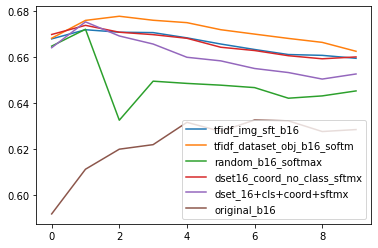

In [5]:
import os
import pandas as pd
import glob
import sys

df = pd.DataFrame()
files = glob.glob("../map/*.csv")
for file in files:
    map_csv=pd.read_csv(file)
    dat1 = pd.DataFrame({file.split('/')[2].split('.')[0]: map_csv['Value']})
    df=pd.concat([df,dat1],axis=1)
#     df.drop(columns=[""])
    df=df.dropna()

# df.plot()
fig=df.plot().get_figure()
fig.savefig('Map_b16_softmax_comparative.png')

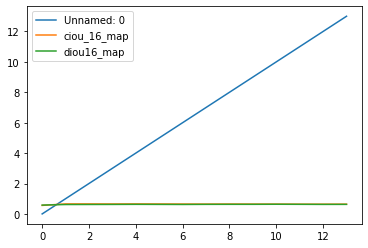

In [5]:
df=pd.read_csv('comparative_map.csv')
fig=df.plot().get_figure()
fig.savefig('comparative_map_iou.png')

<h1>More efficient Yolo</h1>

In [1]:
from dataset import *
import timeit 
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import time
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import test as tester
import sys
import timeit
import torch.autograd
import helper as helper
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from torch import autograd



model = Darknet("../cfg/yolov3.cfg")
inp_dim=model.inp_dim
pw_ph=model.pw_ph.to(device='cuda')
cx_cy=model.cx_cy.to(device='cuda')
stride=model.stride.to(device='cuda')
print('YOLO version2')

hyperparameters={'lr': 0.0001, 
                 'epochs': 90,
                 'resume_from':15,
                 'coco_version': '2017', #can be either '2014' or '2017'
                 'batch_size': 14,
                 'weight_decay': 0.005,
                 'momentum': 0.9, 
                 'optimizer': 'sgd', 
                 'alpha': 0.1, 
                 'gamma': 1.1, 
                 'lcoord': 5,
                 'lno_obj': 1,
                 'iou_type': (1, 0, 0),
                 'iou_ignore_thresh': 0.2, 
                 'tfidf': True, 
                 'idf_weights': True, 
                 'tfidf_col_names': ['img_freq', 'none', 'none', 'none', 'no_softmax'],
                 'augment': 1, 
                 'workers': 4, 
                 'path': 'yolo2017', 
                 'reduction': 'sum'}

print(hyperparameters)
coco_version=hyperparameters['coco_version']
if (hyperparameters['idf_weights']==True):
    hyperparameters['idf_weights']=pd.read_csv('../idf.csv')
else:
    hyperparameters['idf_weights']=False
        
'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pth/'+hyperparameters['path']+'/'
#     print(PATH)
    weights = torch.load(PATH+hyperparameters['path']+'_last.pth')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Assuming that we https://pytorch.org/docs/stable/data.html#torch.utils.data.Datasetare on a CUDA machine, this should print a CUDA device:
    print(device)
    model.load_state_dict(weights)
    model.to(device)
#     if (torch.cuda.device_count() > 2):
#         print("Using ", torch.cuda.device_count(), "GPUs!")
#         model = nn.DataParallel(net)
#         model.to(device)
#     else:
#         model=net
        
        
except FileNotFoundError:
    try:
        os.mkdir(PATH)
    except FileExistsError:
        print('path already exist')
    print('loading Original pretrained')
    model.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    model.to(device)
        
if hyperparameters['augment']>0:
    transformed_dataset=Coco(partition='train',coco_version=coco_version,transform=transforms.Compose([Augment(hyperparameters['augment']),ResizeToTensor(inp_dim)]))
else:
    transformed_dataset=Coco(partition='train',coco_version=coco_version,transform=transforms.Compose([ResizeToTensor(inp_dim)]))
    


writer = SummaryWriter('../results/'+hyperparameters['path'])
dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=hyperparameters['batch_size']
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True,collate_fn=helper.my_collate, num_workers=hyperparameters['workers'])


if hyperparameters['optimizer']=='sgd':
    optimizer = optim.SGD(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'], momentum=hyperparameters['momentum'])
elif hyperparameters['otimizer']=='adam':
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=3)
mAP_max=0
epochs=hyperparameters['epochs']
resume_from=hyperparameters['resume_from']
break_flag=0
for e in range(resume_from,epochs+resume_from):
    total_loss=0
    write=0
    misses=0
    avg_iou=0
    prg_counter=0
    train_counter=0
    avg_conf=0
    avg_no_conf=0
    avg_pos=0
    avg_neg=0
    for images,targets,img_names in dataloader:
        train_counter=train_counter+1
        optimizer.zero_grad()
    #         targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
        images=images.cuda()
        
        raw_pred = model(images, torch.cuda.is_available())
    #         raw_pred=helper.expand_predictions(raw_pred,mask)
        true_pred=util.transform(raw_pred.clone().detach(),pw_ph,cx_cy,stride)

        targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
        targets=targets.cuda()
        fall_into_mask=util.get_fall_into_mask(targets,offset,strd,inp_dim)
        resp_raw_pred,resp_true_pred,resp_anchors,resp_offset,resp_strd=util.build_tensors(raw_pred,true_pred,anchors,offset,strd,fall_into_mask,mask)

        iou,iou_mask=util.get_iou_mask(targets,resp_true_pred,inp_dim,hyperparameters)
        iou=iou.T.max(dim=1)[0].mean().item()
        no_obj_mask=util.get_noobj(true_pred,targets,fall_into_mask,mask,hyperparameters,inp_dim)
        k=0
        no_obj=[]
        for f,i in no_obj_mask:
            no_obj.append(raw_pred[k,f][i][:,4])
            k=k+1
        no_obj=torch.cat(no_obj)
        no_obj_conf=torch.sigmoid(no_obj.clone().detach()).mean().item()

        resp_raw_pred=resp_raw_pred[iou_mask]
        resp_anchors=resp_anchors[iou_mask]
        resp_offset=resp_offset[iou_mask]
        resp_strd=resp_strd[iou_mask]
        conf=resp_true_pred[iou_mask][:,4].mean().item()
        class_mask=targets[:,5:].type(torch.BoolTensor).squeeze(0)
#         lista=resp_offset.tolist()
#         final=[]
#         for sl in lista:
#             final.append(''.join(str(sl)))
            
#         print('ratio is :', len(set(final))/len(lista))

        if(iou_mask.sum()==class_mask.shape[0]):
            pos_class=resp_true_pred[iou_mask][:,5:][class_mask].mean().item()
            neg_class=resp_true_pred[iou_mask][:,5:][~class_mask].mean().item()
        else:
            pos_class=0
            neg_class=0
#         break
        loss=util.yolo_loss(resp_raw_pred,targets,no_obj,mask,resp_anchors,resp_offset,resp_strd,inp_dim,hyperparameters)
        loss.backward()
        optimizer.step()

        avg_conf=avg_conf+conf
        avg_no_conf=avg_no_conf+no_obj_conf
        avg_pos=avg_pos+pos_class
        avg_neg=avg_neg+neg_class
        total_loss=total_loss+loss.item()
        avg_iou=avg_iou+iou
        prg_counter=prg_counter+1
        sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100*batch_size)+'%' ' L:'+ str(loss.item()))
        sys.stdout.write(' IoU:' +str(iou)+' pob:'+str(conf)+ ' nob:'+str(no_obj_conf))
        sys.stdout.write(' PCls:' +str(pos_class)+' ncls:'+str(neg_class))
        sys.stdout.flush()
        del resp_raw_pred,resp_true_pred,resp_anchors,resp_offset,resp_strd,images,targets,anchors,offset,strd,mask,img_names,no_obj,iou,iou_mask,fall_into_mask
        torch.cuda.empty_cache()
        
        writer.add_scalar('AvLoss/train', total_loss/train_counter, train_counter)

        
        writer.add_scalar('AvIoU/train', avg_iou/train_counter, train_counter)

        writer.add_scalar('AvPConf/train', avg_conf/train_counter, train_counter)
        
        writer.add_scalar('AvNConf/train', avg_no_conf/train_counter, train_counter)
        
        writer.add_scalar('AvClass/train', avg_pos/train_counter, train_counter)
        
        writer.add_scalar('AvNClass/train', avg_neg/train_counter, train_counter)
    break       
    mAP=tester.get_map(model,confidence=0.1,iou_threshold=0.5,coco_version=coco_version)
    writer.add_scalar('Loss/train', total_loss/train_counter, e)
    writer.add_scalar('AIoU/train', avg_iou/train_counter, e)
    writer.add_scalar('PConf/train', avg_conf/train_counter, e)
    writer.add_scalar('NConf/train', avg_no_conf/train_counter, e)
    writer.add_scalar('PClass/train', avg_pos/train_counter, e)
    writer.add_scalar('NClass/train', avg_neg/train_counter, e)
    writer.add_scalar('mAP/valid', mAP, e)
    
    if mAP>mAP_max:
        torch.save(model.state_dict(),PATH+hyperparameters['path']+'_best.pth')
        torch.save(model.state_dict(),PATH+hyperparameters['path']+'_last.pth')
        mAP_max=mAP
    else:
        torch.save(model.state_dict(),PATH+hyperparameters['path']+'_last.pth')
    scheduler.step(mAP) 
    if break_flag==1:
        print(mAP)
        print('Pgr:'+str(prg_counter/dataset_len*100*batch_size)+'%' ' L:'+ str(loss.item()))
        break
    print('\ntotal number of misses is ' + str(misses))
    print('\n total average loss is '+str(total_loss/train_counter))
    print('\n total average iou is '+str(avg_iou/train_counter))

YOLO version2
{'lr': 0.0001, 'epochs': 90, 'resume_from': 15, 'coco_version': '2017', 'batch_size': 14, 'weight_decay': 0.005, 'momentum': 0.9, 'optimizer': 'sgd', 'alpha': 0.1, 'gamma': 1.1, 'lcoord': 5, 'lno_obj': 1, 'iou_type': (1, 0, 0), 'iou_ignore_thresh': 0.2, 'tfidf': True, 'idf_weights': True, 'tfidf_col_names': ['img_freq', 'none', 'none', 'none', 'no_softmax'], 'augment': 1, 'workers': 4, 'path': 'yolo2017', 'reduction': 'sum'}
cuda:0
Length of dataset is 58633

Pgr:0.11938669350024729% L:3.705775022506714 IoU:0.7823742032051086 pob:0.3901668190956116 nob:0.0004780368763022125 PCls:0.7768087983131409 ncls:0.00282520544715225754

KeyboardInterrupt: 

In [2]:
images=images.cpu()

In [3]:
mean=torch.tensor([[[0.485, 0.456, 0.406]]]).T
std=torch.tensor([[[0.229, 0.224, 0.225]]]).T

In [4]:
images = [(i*std+mean) for i in images]

In [5]:
images = [i*255.0 for i in images]

In [6]:
imgs =  [i.transpose(0,2) for i in images]
imgs =  [i.transpose(1,0) for i in imgs]

<ipython-input-7-72fdca166620>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  im=torch.tensor(imgs[0],dtype=torch.int)
/users/konsa15/.conda/envs/faster_rcnn/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


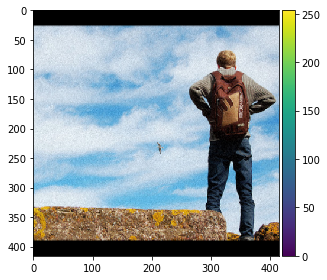

In [7]:
from skimage import io
import cv2 as cv
im=torch.tensor(imgs[0],dtype=torch.int)
im=im.numpy()
io.imshow(im)


In [57]:
print(targets.shape)
print(mask)

torch.Size([130, 85])
[21, 2, 10, 7, 9, 17, 14, 1, 8, 2, 24, 2, 8, 5]


[[179.15515  234.65056  185.26428  362.69888 ]
 [313.8156   236.5163   147.50708  350.86835 ]
 [ 96.86535  233.8998     8.464897  16.302814]
 [243.00371  162.6203    18.67421   48.148735]
 [139.50368  158.72679    4.734955  17.518837]
 [290.4646   148.2486    10.851864  14.57655 ]]


<ipython-input-28-fab51ed531d1>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  im=torch.tensor(imgs[k],dtype=torch.int)


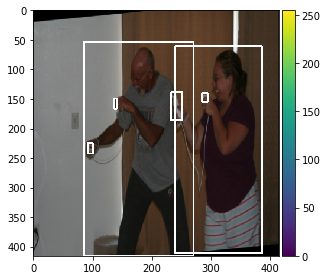

In [28]:
k=13
im=torch.tensor(imgs[k],dtype=torch.int)
im=im.numpy()
temp_sum=sum([mask[i] for i in range(k)])
boxes1=targets[temp_sum:temp_sum+mask[k],:4].cpu().numpy()
print(boxes1)
io.imshow(draw_rect(im,boxes1))


array([[0.43267298, 0.49215   , 0.8653449 , 0.9843    ]], dtype=float32)

In [12]:
import cv2 
import pickle as pkl
import numpy as np 
import matplotlib.pyplot as plt

def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """
    
    im = im.copy()
    h=im.shape[0]
    w=im.shape[1]
#     cords[:,0]=cords[:,0]*w
#     cords[:,1]=cords[:,1]*h
#     cords[:,2]=cords[:,2]*w
#     cords[:,3]=cords[:,3]*h
    if not color:
        color = [255,255,255]
    for cord in cords:
        pt1, pt2 = (cord[0]-cord[2]/2, cord[1]-cord[3]/2) , (cord[0]+cord[2]/2, cord[1]+cord[3]/2)
        
#         pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
        
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

In [4]:
from dataset import *
import timeit 
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import time
from darknet import *
import util as util
import torch.optim as optim
import test as tester
import sys
import timeit
import torch.autograd
import helper as helper
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import yolo_function as yolo_function



hyperparameters={'lr': 0.001, 
                 'epochs': 90,
                 'resume_from':15,
                 'coco_version': '2017', #can be either '2014' or '2017'
                 'batch_size': 8,
                 'weight_decay': 0.0005,
                 'momentum': 0.9, 
                 'optimizer': 'sgd', 
                 'alpha': 0.9, 
                 'gamma': 2, 
                 'lcoord': 5,
                 'lno_obj': 1,
                 'iou_type': (0, 0, 0),
                 'iou_ignore_thresh': 0.5, 
                 'tfidf': True, 
                 'idf_weights': True, 
                 'tfidf_col_names': ['img_freq', 'none', 'none', 'none', 'no_softmax'],
                 'augment': 0, 
                 'workers': 4, 
                 'path': 'yolo2017',
                 'pretrained':True,
                 'reduction': 'mean'}

mode={'bayes_opt':False,
      'debugging':False,
      'show_output':True,
      'show_summary':True,
      'multi_gpu':False
     }

net = Darknet("../cfg/yolov3.cfg")

coco_version=hyperparameters['coco_version']
inp_dim=net.inp_dim

if hyperparameters['augment']>0:
    train_dataset=Coco(partition='train',coco_version=coco_version,transform=transforms.Compose([Augment(hyperparameters['augment']),ResizeToTensor(inp_dim)]))
else:
    train_dataset=Coco(partition='train',coco_version=coco_version,transform=transforms.Compose([ResizeToTensor(inp_dim)]))
    
dataset_len=(len(train_dataset))
print('Training with: ',dataset_len)

train_dataloader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'],
                            shuffle=True,collate_fn=helper.my_collate, num_workers=hyperparameters['workers'])


yolo_function.train_one_epoch(net,train_dataloader,hyperparameters,mode)

Training with:  117266
Using:  cuda:0
Pgr:13.82839015571436% L:0.46838730573654175 IoU:0.7569687962532043 pob:0.9416791200637817 nob:0.04137937352061272 PCls:0.9240989685058594 ncls:0.000960772391408681964

KeyboardInterrupt: 

In [5]:
torch.save({
'model_state_dict': model.state_dict(),
'optimizer_state_dict': optimizer.state_dict(),
'avg_loss': total_loss/train_counter,
'avg_iou': avg_iou/train_counter,
'avg_pos': avg_pos/train_counter,
'avg_neg':avg_neg/train_counter,
'avg_conf': avg_conf/train_counter,
'avg_no_conf': avg_no_conf/train_counter
}, PATH+hyperparameters['path']+'.tar')

In [3]:
hyperparameters['idf_weights']=True

In [4]:
print(true_pred[:,:,4].mean())
print(true_pred[0,:,4].max())
print(true_pred[7,:,4].min())
print(true_pred[0,:,4].std())

tensor(0.0200, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3217, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0005, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0347, device='cuda:0', grad_fn=<StdBackward0>)


In [3]:
print(true_pred.shape)

torch.Size([8, 10647, 85])


In [2]:
from scipy.stats import entropy
noobj_score=no_obj[:,0].cpu().detach().numpy()

In [3]:
print(noobj_score.shape)

(84753,)


In [7]:
import torch.nn.functional as F
criterion = nn.KLDivLoss(reduction='none')
rndm=torch.rand((no_obj.shape[0],no_obj.shape[1]-1)).cuda()
# rndm=torch.softmax(rndm,dim=0)
print(rndm.shape)
print(true_pred[0,:,4].cpu().detach().numpy()[:,1:].shape)
out = criterion(no_obj[:,1:],rndm).sum(axis=1)
out=out.cpu().detach().numpy()


torch.Size([84492, 80])
torch.Size([84492, 80])


In [14]:
print(true_pred[1,:,5:].shape)

torch.Size([10647, 80])


In [5]:
bits=entropy(no_obj[:,1:].cpu().detach().numpy(), base=2,axis=1)
print(bits.mean())
print(bits.std())

6.2089343
0.18661556


In [5]:
# print(bits)
print(bits.mean())
print(bits.std())

2.446281
1.5541406


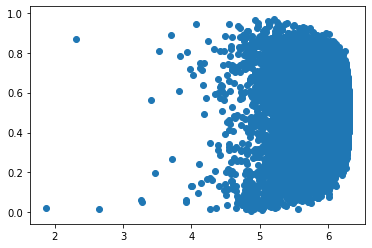

In [6]:
import matplotlib.pyplot as plt
plt.scatter(bits,noobj_score)
# plt.show()
plt.savefig('bits_conf_scatter_rand.png')


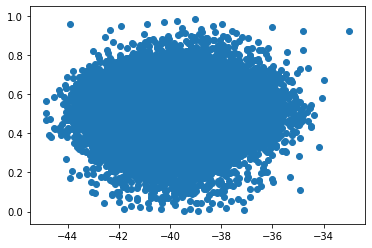

In [28]:
import matplotlib.pyplot as plt
plt.scatter(out,noobj_score)
plt.show()

In [29]:
from scipy.stats import wasserstein_distance
sc_w=[]
for i in range(noobj_score.shape[0]):
    sc_w.append(wasserstein_distance(np.arange(80),np.arange(80),rndm[0,:].cpu(),no_obj[i,1:].cpu().detach().numpy()))
    

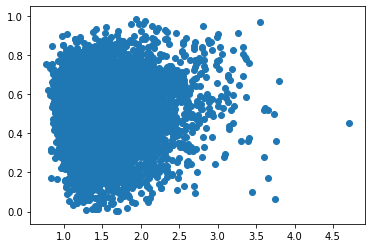

In [30]:
import matplotlib.pyplot as plt
plt.scatter(sc_w,noobj_score)
plt.show()

In [31]:
sc_kl=[]
for i in range(noobj_score.shape[0]):
    sc_kl.append(entropy(rndm[0,:].cpu(),no_obj[i,1:].cpu().detach().numpy()))
    

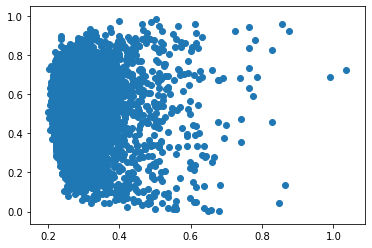

In [32]:
import matplotlib.pyplot as plt
plt.scatter(sc_kl,noobj_score)
plt.show()

In [34]:
kl_score=np.array(sc_kl)
(kl_score*noobj_score>0.2).sum()

1263

In [3]:
from dataset import *
import timeit 
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import time
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import test as tester
import sys
import timeit
import torch.autograd
import helper as helper
from torch.utils.tensorboard import SummaryWriter
import pandas as pd



net = Darknet("../cfg/yolov3.cfg")
net.load_weights("../yolov3.weights")
torch.save(net.state_dict(),'yolov3.pt')

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [ ]:
def sample(no_obj):
    

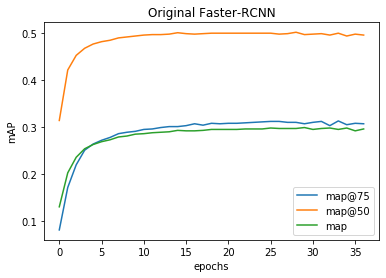

In [37]:
import matplotlib.pyplot as plt
import numpy as np


mAP=[0.131,0.203,0.236,0.254,0.263,0.269,0.273,0.279,0.281,0.285,0.286,0.288,0.289,0.290,0.293,0.292,0.292,0.293,0.295,0.295,0.295,0.295,0.296,0.296,0.296,0.298,0.297,0.297,0.297,0.299,0.295,0.297,0.298,0.295,0.298,0.292,0.296]
map50=[0.314,0.421,0.452,0.467,0.476,0.481,0.484,0.489,0.491,0.493,0.495,0.496,0.496,0.497,0.500,0.498,0.497,0.498,0.499,0.499,0.499,0.499,0.499,0.499,0.499,0.499,0.497,0.498,0.501,0.496,0.497,0.498,0.495,0.499,0.493,0.497,0.495]
map75=[0.082,0.172,0.220,0.251,0.264,0.272,0.278,0.286,0.289,0.291,0.295,0.296,0.299,0.301,0.301,0.303,0.307,0.304,0.308,0.307,0.308,0.308,0.309,0.310,0.311,0.312,0.312,0.310,0.310,0.307,0.310,0.312,0.303,0.313,0.305,0.308,0.307]
epochs=np.arange(len(mAP))
plt.title('Original Faster-RCNN')
plt.plot(epochs,map75,map50)
plt.plot(epochs,mAP)
plt.legend(['map@75','map@50','map'])
plt.xlabel('epochs')
plt.ylabel('mAP')
# plt.show()
plt.savefig('vanilla_faster_rcnn')


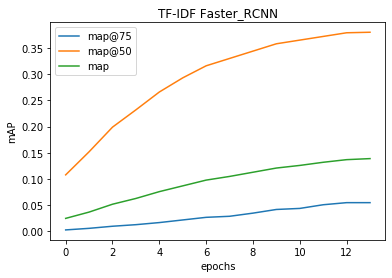

In [38]:
tf_map75=[0.003,0.006,0.010,0.013,0.017,0.022,0.027,0.029,0.035,0.042,0.044,0.051,0.055,0.055]
tf_map=[0.025,0.037,0.052,0.063,0.076,0.087,0.098,0.105,0.113,0.121,0.126,0.132,0.137,0.139]
tf_map50=[0.108,0.152,0.199,0.232,0.266,0.293,0.316,0.330,0.344,0.358,0.365,0.372,0.379,0.380]
epochs=np.arange(len(tf_map))
plt.title('TF-IDF Faster_RCNN')
plt.plot(epochs,tf_map75,tf_map50)
plt.plot(epochs,tf_map)
plt.legend(['map@75','map@50','map'])
plt.xlabel('epochs')
plt.ylabel('mAP')
plt.savefig('tf_idf_faster_rcnn')


In [18]:
map50=[[0.314,0.421,0.452,0.467,0.476,0.481,0.484,0.489,0.491,0.493,0.495,0.496,0.496,0.497,0.500,0.498,0.497,0.498,0.499,0.499,0.499,0.499,0.499,0.499,0.499,0.499,0.499,0.497,0.498,0.501,0.496,0.497,0.498,0.495,0.499,0.493,0.497,0.495]]

In [95]:
test=torch.tensor([1,1,2,3,2,3,2,1,1])
print(test.max(axis=0))

torch.return_types.max(
values=tensor(3),
indices=tensor(5))


torch.Size([84275])


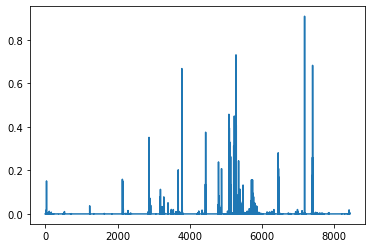

In [13]:
print(no_obj.shape)
no_obj_vis=no_obj.cpu().detach().numpy()
import matplotlib.pyplot as plt

t = np.arange(0., no_obj.shape[0]/10, 0.1)

plt.plot(t,no_obj_vis)
plt.show()

In [13]:
torch.save(model.state_dict(),PATH+hyperparameters['path']+'_best.pth')

In [44]:
print(mask)
import matplotlib.pyplot as plt
from scipy.stats import entropy
print(fall_into_mask.shape)
prev=0
counter=0
no_obj=[]
iou_ignore_thresh=0.5
iou_type=hyperparameters['iou_type']
for i in mask:
    print('starts with ', true_pred.shape)
    combined_fall_into_mask=fall_into_mask[prev:prev+i,:].sum(axis=0,dtype=torch.bool)
    print('total responsible boxes are',sum(combined_fall_into_mask))
    noobj=true_pred[counter,~combined_fall_into_mask,4]
    noobj_class=true_pred[counter,~combined_fall_into_mask,5:]
    print('after the responsibles',noobj.shape)
    abs_box=get_abs_coord(true_pred[counter,~combined_fall_into_mask,:4])
    abs_box=abs_box.unsqueeze(1)
    targets2=get_abs_coord(targets[:,:4]*inp_dim).unsqueeze(0)
    ignore_iou=bbox_iou(abs_box,targets2[:,prev:i+prev,:],iou_type,CUDA=True)
    ignore_iou_mask=(ignore_iou>iou_ignore_thresh).sum(axis=1,dtype=torch.bool)
    prev=i+prev
    
    no_obj.append(noobj[~ignore_iou_mask])
    
    print(noobj_class[~ignore_iou_mask][noobj[~ignore_iou_mask].max(axis=0)[1]])
    print('after the iou_mask',no_obj[counter].shape)
    counter=counter+1
no_obj=torch.cat(no_obj)

[2, 2, 14, 13, 21, 14, 3, 2]
torch.Size([71, 10647])
starts with  torch.Size([8, 10647, 85])
total responsible boxes are tensor(18, device='cuda:0')
after the responsibles torch.Size([10629])
tensor([3.6995e-05, 9.7969e-01, 8.3973e-06, 6.6107e-04, 6.8324e-06, 7.7150e-06,
        1.7017e-03, 1.5046e-05, 5.3098e-06, 3.8264e-06, 1.5289e-04, 8.9902e-06,
        1.0507e-05, 1.2276e-02, 6.5301e-06, 1.1321e-05, 1.3700e-05, 2.4070e-05,
        4.1686e-07, 1.4750e-06, 4.8564e-07, 7.1232e-07, 5.0895e-05, 1.3348e-05,
        1.8290e-05, 9.1021e-05, 1.7075e-04, 1.8890e-04, 2.4536e-04, 4.4851e-06,
        7.1863e-04, 1.4668e-04, 1.6816e-06, 2.8300e-06, 1.5926e-05, 1.5950e-05,
        1.8857e-04, 6.2193e-07, 6.0821e-05, 8.9504e-05, 1.9550e-05, 8.3533e-06,
        3.3542e-05, 1.2011e-05, 1.0673e-05, 1.7135e-06, 5.3587e-05, 7.8259e-06,
        2.3435e-06, 6.0861e-06, 4.7711e-06, 1.9119e-05, 9.4627e-06, 2.0558e-05,
        9.5055e-07, 1.1929e-06, 1.1253e-04, 1.8614e-05, 2.2227e-05, 1.4867e-04,
        

In [41]:
print(true_pred[:,:,5:85].sum(axis=2).max())

tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


In [46]:
print(no_obj.shape)
print(no_obj.max(axis=0))
print(no_obj.mean())
print(no_obj.std())

torch.Size([84275])
torch.return_types.max(
values=tensor(0.9091, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(71792, device='cuda:0'))
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0080, device='cuda:0', grad_fn=<StdBackward0>)


In [28]:
# print(util.xyxy_to_xywh(targets[:,:4]/inp_dim))
print(targets)

tensor([[0.5050, 0.7038, 0.9900,  ..., 0.0000, 0.0000, 0.0000],
        [0.6103, 0.6420, 0.6327,  ..., 0.0000, 0.0000, 0.0000],
        [0.4738, 0.6358, 0.0616,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4342, 0.6745, 0.1571,  ..., 0.0000, 0.0000, 0.0000],
        [0.5431, 0.6135, 0.3644,  ..., 0.0000, 0.0000, 0.0000],
        [0.5759, 0.3082, 0.3563,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')


In [62]:

# ignore_threshold=hyperparameters['iou_ignore_thresh']
iou_type=hyperparameters['iou_type']
#multiply by inp_dim then devide by stride to get the relative grid size coordinates, floor the result to get the corresponding cell
target_xc=targets[:,0:1]
target_yc=targets[:,1:2]
strd=strd.squeeze()

centered_x=torch.floor(target_xc*inp_dim/strd)
centered_y=torch.floor(target_yc*inp_dim/strd)
fall_into_mask=(centered_x==offset[:,:,0])&(centered_y==offset[:,:,1])
k=0

responsible_boxes=torch.empty([sum(mask),9,true_pred.shape[2]],device='cuda')
k=0
counter=0
for i in mask:
    for j in range(i):
        responsible_boxes[k,:,:]=true_pred[counter,fall_into_mask[k]]
        k=k+1
    counter=counter+1
# print(responsible_boxes.shape)
counter=0
k=0
raw_pred_reduced=torch.empty([sum(mask),9,true_pred.shape[2]],device='cuda')
for i in mask:
    for j in range(i):
        raw_pred_reduced[k,:,:]=raw_pred[counter,fall_into_mask[k]]
        k=k+1
    counter=counter+1
# fall_into_mask=torch.tensor(new,dtype=torch.bool)
ind=1
targets2=targets.clone()
# print(targets2[ind,:4])
targets2[:,:4]=targets2[:,:4]*inp_dim

targets2[:,:4]=get_abs_coord(targets2[:,:4])
targets2=targets2.unsqueeze(0)
print(targets2)
# print('centered are:\n',responsible_boxes[ind,:,:4])
new_pred=get_abs_coord(responsible_boxes)
print('absolute are:\n',new_pred[:,ind,:4])
print(new_pred.shape)
print("targets are\n",targets2[:,ind:ind+1,:4])
# iou=bbox_iou(targets2[:,ind:ind+1,:4],new_pred[:,ind:ind+1,:4],(0,0,0),CUDA=True)
iou=bbox_iou(targets2[:,:,:4],new_pred[:,:,:4],(0,0,0),CUDA=True)
print(iou.shape)
print(iou.T.max(dim=1)[0])
iou_mask=iou.T==(iou.T.max(dim=1)[0].unsqueeze(1))
print(iou_mask[0])


tensor([[[402.6938, 349.7602, 258.5788,  ...,   0.0000,   0.0000,   0.0000],
         [102.6004, 104.8167, 325.5792,  ...,   0.0000,   0.0000,   0.0000],
         [345.8141, 216.3298, 406.2784,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [406.5146, 372.9048, 284.1584,  ...,   0.0000,   0.0000,   0.0000],
         [499.7340, 326.5751, 284.9585,  ...,   0.0000,   0.0000,   0.0000],
         [481.8523,  52.5700, 222.2110,  ...,   0.0000,   0.0000,   0.0000]]],
       device='cuda:0')
absolute are:
 tensor([[137.9143, 129.6414, 277.8270, 221.6816],
        [ 92.6148,  84.7742, 324.1161, 277.1817],
        [  6.8312,  20.8891, 413.3181, 345.0369],
        [205.3303, 145.4310, 232.1554, 220.2946],
        [172.8849, 161.1026, 262.2605, 202.6731],
        [193.9224, 121.6522, 244.4809, 247.4643],
        [208.3934, 185.1510, 215.1547, 191.9462],
        [207.2451, 168.0392, 217.4877, 209.0175],
        [185.5531, 181.1787, 239.5982, 196.0757]], device='cuda:0',
       grad_fn=

In [7]:
iou2,iou_mask2=util.get_iou_mask(targets,resp_raw_pred,inp_dim,hyperparameters)

In [8]:
print(iou_mask2[0])

tensor([True, True, True, True, True, True, True, True, True], device='cuda:0')


In [9]:
import torchvision.ops.boxes as nms_box
ind=3
test2=(targets2[:,ind:ind+1,:4]).squeeze(0)
print(test2)
abs_test2_box=get_abs_coord(true_pred[1,:,:4]).squeeze(1)

print(abs_test2_box[fall_into_mask[ind]])
iou_test2=(nms_box.box_iou(test2,abs_test2_box))

iou_test2[:,fall_into_mask[ind]]

tensor([[149.7798, 105.1205, 294.2095, 353.0544]], device='cuda:0')
tensor([[142.8968, 195.8982, 277.4266, 280.3114],
        [143.8645, 106.1081, 298.3638, 355.0065],
        [ 73.5214,  77.5211, 335.7871, 393.4481],
        [196.8103, 207.6879, 225.9148, 260.7679],
        [188.0461, 211.0362, 238.0284, 252.2840],
        [184.7895, 147.1484, 242.7385, 317.1068],
        [215.8879, 224.9017, 224.0075, 231.1994],
        [210.6102, 213.5516, 226.1777, 242.5695],
        [200.5163, 216.9525, 240.5707, 236.7741]], device='cuda:0',
       grad_fn=<IndexBackward>)


tensor([[0.2961, 0.9241, 0.4322, 0.0431, 0.0576, 0.2750, 0.0014, 0.0126, 0.0222]],
       device='cuda:0', grad_fn=<IndexBackward>)

In [10]:
print(mask)
test=targets[:,:].unsqueeze(0)
print(true_pred.shape)
print(test.shape)
abs_test_box=get_abs_coord(true_pred[0:1,:,:4])
print(abs_test_box.shape)
test_iou=bbox_iou(abs_test_box,test,(0,0,0),CUDA=True)
print(test_iou.shape)
ignore_iou_mask=(test_iou<0.3).sum(axis=1,dtype=torch.bool)
print(ignore_iou_mask.sum())
print(test_iou[:,0].max())
print(test_iou[:,1].max())

[2, 2, 14, 13, 21, 14, 3, 2]
torch.Size([8, 10647, 85])
torch.Size([1, 71, 85])
torch.Size([10647, 1, 4])
torch.Size([10647, 71])
tensor(10647, device='cuda:0')
tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.8069e-05, device='cuda:0', grad_fn=<MaxBackward1>)


In [7]:
targets=targets.unsqueeze(0)

In [63]:
prev=0
counter=0
no_obj=[]


for i in mask:
    combined_fall_into_mask=fall_into_mask[prev:prev+i,:].sum(axis=0,dtype=torch.bool)
    print('starts with ',true_pred[counter,:,:].shape)  
    noobj=true_pred[counter,~combined_fall_into_mask,4]
    print('after the responsible ',noobj.shape)
    abs_box=get_abs_coord(true_pred[counter,~combined_fall_into_mask,:4])
    abs_box=abs_box.unsqueeze(1)
    print('abs shape is:',abs_box.shape)
    ignore_iou=bbox_iou(abs_box,targets[:,prev:i+prev,:],(0,0,0),CUDA=True)
    print('ignore_io shape is',ignore_iou.shape)
    ignore_iou_mask=(ignore_iou>0.5).sum(axis=1,dtype=torch.bool)
    print('number of objects is:',ignore_iou_mask.sum())
    print('max is ',ignore_iou.max())
    
    
    prev=i
    
    no_obj.append(noobj[~ignore_iou_mask])
#     del ignore_iou_mask
    print('after the iou_mask',no_obj[counter].shape)
    counter=counter+1
#     no_obj.append(true_pred[counter,(~combined_fall_into_mask),4])

no_obj=torch.cat(no_obj)
print(no_obj.shape)

starts with  torch.Size([10647, 85])
after the responsible  torch.Size([10593])
abs shape is: torch.Size([10593, 1, 4])


IndexError: too many indices for tensor of dimension 2

In [36]:
print()

tensor([1, 1])


In [102]:

bad_iou=bbox_iou(new_bad_pred,targets2,(0,0,0),CUDA=True)
print(bad_iou.shape)
ignore_iou_mask=bad_iou<0.75
print(ignore_iou_mask.shape)
print(fall_into_mask.shape)
counter=0
prev=0
no_obj_mask=torch.empty([true_pred.shape[1]-9,len(mask)],device='cuda')
combined_fall_into_mask=torch.empty([len(mask),true_pred.shape[1]],device='cuda',dtype=torch.bool)
for i in mask:
    no_obj_mask[:,counter]=ignore_iou_mask[:,prev:i].sum(axis=1,dtype=torch.bool)
    combined_fall_into_mask[counter,:]=fall_into_mask[prev:i,:].sum(axis=0,dtype=torch.bool)
    prev=i
    counter=counter+1
combined_fall_into_mask=~combined_fall_into_mask
print(no_obj_mask.shape)
print(combined_fall_into_mask.shape)
print(true_pred[combined_fall_into_mask].shape)

torch.Size([10638, 71, 4])
torch.Size([10638, 71])
torch.Size([10638, 71])
torch.Size([71, 10647])
torch.Size([10638, 8])
torch.Size([8, 10647])
torch.Size([84987, 85])


In [ ]:
counter=0
k=0
raw_pred_reduced=torch.empty([sum(mask),9,true_pred.shape[2]],device='cuda')
for i in mask:
    for j in range(i):
        raw_pred_reduced[k,:,:]=raw_pred[counter,fall_into_mask[k]]
        k=k+1
    counter=counter+1

In [2]:
def get_abs_coord(box):
    # yolo predicts center coordinates
    if torch.cuda.is_available():
        box=box.cuda()
    if (len(box.shape)==3):
        x1 = (box[:,:,0] - box[:,:,2]/2) 
        y1 = (box[:,:,1] - box[:,:,3]/2) 
        x2 = (box[:,:,0] + box[:,:,2]/2) 
        y2 = (box[:,:,1] + box[:,:,3]/2)
    else:
        x1 = (box[:,0] - box[:,2]/2) 
        y1 = (box[:,1] - box[:,3]/2) 
        x2 = (box[:,0] + box[:,2]/2) 
        y2 = (box[:,1] + box[:,3]/2)
    return torch.stack((x1, y1, x2, y2)).T

In [5]:
def bbox_iou(box1, box2,iou_type,CUDA=True):
    # Returns the IoU of box1 to box2. box1 is 4, box2 is nx4
    GIoU, DIoU, CIoU=iou_type
    
    if CUDA:
        box2 = box2.cuda()
        box1 = box1.cuda()
        
    print(box1.shape)
    print(box2.shape)

    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,:,0], box1[:,:,1], box1[:,:,2], box1[:,:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,:,0], box2[:,:,1], box2[:,:,2], box2[:,:,3]

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
            (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)

    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1
    union = (w1 * h1 + 1e-16) + w2 * h2 - inter

    iou = inter / union  # iou
    if GIoU or DIoU or CIoU:
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if GIoU:  # Generalized IoU https://arxiv.org/pdf/1902.09630.pdf
            c_area = cw * ch + 1e-16  # convex area
            return iou - (c_area - union) / c_area  # GIoU
        if DIoU or CIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            # convex diagonal squared
            c2 = cw ** 2 + ch ** 2 + 1e-16
            # centerpoint distance squared
            rho2 = ((b2_x1 + b2_x2) - (b1_x1 + b1_x2)) ** 2 / 4 + ((b2_y1 + b2_y2) - (b1_y1 + b1_y2)) ** 2 / 4
            if DIoU:
                return iou - rho2 / c2  # DIoU
            elif CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * torch.pow(torch.atan(w2 / h2) - torch.atan(w1 / h1), 2)
                with torch.no_grad():
                    alpha = v / (1 - iou + v)
                return iou - (rho2 / c2 + v * alpha)  # CIoU

    return iou

In [1]:
import os
import pandas as pd
from shutil import copyfile
# copyfile(src, dst)

val2014=pd.read_csv('../pointers/val2014.txt',names=['name'])


In [2]:
val2014.head()

,name
0,train2017/000000000164.jpg
1,train2017/000000000192.jpg
2,train2017/000000000283.jpg
3,train2017/000000000397.jpg
4,train2017/000000000589.jpg


In [1]:
from shutil import copy
k=0
nok=0
for n in val2014['name']:
    n=n.split('.')[0]+'.txt'
    temp_path="../labels/coco/labels/"+n
    n=n.split("/")[-1]
    try:
        copyfile(temp_path, '../labels/coco/labels/val2014/'+n)
        k=k+1
    except FileNotFoundError:
        nok=nok+1

NameError: name 'val2014' is not defined

In [3]:
val2014['raw_name']=val2014['name'].map(lambda x: x.split('/')[1])
val2014['partition']=val2014['name'].map(lambda x: x.split('/')[0])

In [4]:
val2014

,name,raw_name,partition
0,train2017/000000000164.jpg,000000000164.jpg,train2017
1,train2017/000000000192.jpg,000000000192.jpg,train2017
2,train2017/000000000283.jpg,000000000283.jpg,train2017
3,train2017/000000000397.jpg,000000000397.jpg,train2017
4,train2017/000000000589.jpg,000000000589.jpg,train2017
...,...,...,...
4995,train2017/000000581655.jpg,000000581655.jpg,train2017
4996,train2017/000000581731.jpg,000000581731.jpg,train2017
4997,val2017/000000581781.jpg,000000581781.jpg,val2017
4998,train2017/000000581887.jpg,000000581887.jpg,train2017


In [28]:
train2017=pd.read_csv('../pointers/train2017.txt',names=['name'])
val2017=pd.read_csv('../pointers/val2017.txt',names=['name'])

In [29]:
train2017['isinval']=train2017['name'].isin(val2014['raw_name'])
val2017['isinval']=val2017['name'].isin(val2014['raw_name'])

In [38]:
# print(train2017['isinval'])
# print(val2017['isinval'])
train2017=train2017[~train2017['isinval']]
val2017=val2017[~val2017['isinval']]
# train2014=pd.concat([train2017[~train2017['isinval']],val2017[~val2017['isinval']]])

In [46]:
train2014=pd.concat([train2017,val2017],axis=0,ignore_index=True)

In [47]:

train2014['isintrain']=train2014['name'].isin(train2017['name'])

In [48]:
train2014['isintrain']

0          True
1          True
2          True
3          True
4          True
          ...  
117259    False
117260    False
117261    False
117262    False
117263    False
Name: isintrain, Length: 117264, dtype: bool

In [49]:
for i,row in train2014.iterrows():
    if row['isintrain']:
        train2014['name'].iloc[i]='train2017/'+row['name']
    else:
        train2014['name'].iloc[i]='val2017/'+row['name']

/users/konsa15/.conda/envs/faster_rcnn/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [50]:
print(train2014)

                              name  isinval  isintrain
0       train2017/000000109622.jpg    False       True
1       train2017/000000160694.jpg    False       True
2       train2017/000000308590.jpg    False       True
3       train2017/000000327573.jpg    False       True
4       train2017/000000062929.jpg    False       True
...                            ...      ...        ...
117259    val2017/000000467315.jpg    False      False
117260    val2017/000000032861.jpg    False      False
117261    val2017/000000491497.jpg    False      False
117262    val2017/000000264335.jpg    False      False
117263    val2017/000000502599.jpg    False      False

[117264 rows x 3 columns]


In [51]:
train2014=train2014.drop(['isinval'],axis=1)
train2014=train2014.drop(['isintrain'],axis=1)

In [52]:
print(train2014)

                              name
0       train2017/000000109622.jpg
1       train2017/000000160694.jpg
2       train2017/000000308590.jpg
3       train2017/000000327573.jpg
4       train2017/000000062929.jpg
...                            ...
117259    val2017/000000467315.jpg
117260    val2017/000000032861.jpg
117261    val2017/000000491497.jpg
117262    val2017/000000264335.jpg
117263    val2017/000000502599.jpg

[117264 rows x 1 columns]


In [53]:
train2014.to_csv('../pointers/train2014.txt',index=False)